# 1. Set up the notebook

Import modules.

In [1]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

Define a function to load data from hardware and resample it at 100 Hz using linear interpolation.

In [2]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [3]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 2. Derive models

## 2.1 Define symbolic variables

Define states.

In [4]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

Define inputs.

In [5]:
# gyroscope measurements - components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# z-axis accelerometer measurement - specific force (meters / second^2)
a_z = sym.symbols('a_z')

Define outputs.

In [6]:
x_meas, y_meas, z_meas = sym.symbols('x_meas, y_meas, z_meas')

Define parameters.

In [7]:
g, k_flow = sym.symbols('g, k_flow')

Create linear and angular velocity vectors (in coordinates of the body frame).

In [8]:
v_01in1 = sym.Matrix([[v_x], [v_y], [v_z]])
w_01in1 = sym.Matrix([[w_x], [w_y], [w_z]])

## 2.2 Define kinematics of orientation

### 2.2.1 Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [9]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame 1 in the coordinates of frame 0).

In [10]:
R_1in0 = Rz * Ry * Rx

### 2.2.2 Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [11]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([[0], [0], [1]]),
                              (Rx).T * sym.Matrix([[0], [1], [0]]),
                                       sym.Matrix([[1], [0], [0]]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [12]:
N = sym.simplify(Ninv.inv())

## 2.3 Derive equations of motion

Ratio of net thrust to mass in terms of z-axis accelerometer measurement.

In [13]:
f_z_over_m = a_z + (w_01in1.cross(v_01in1))[2]

Ratio of forces to mass.

In [14]:
f_in1_over_m = R_1in0.T * sym.Matrix([[0], [0], [-g]]) + sym.Matrix([[0], [0], [f_z_over_m]])

Equations of motion.

In [15]:
f = sym.Matrix.vstack(
    R_1in0 * v_01in1,
    N * w_01in1,
    (f_in1_over_m - w_01in1.cross(v_01in1)),
)

Show equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

where

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \end{bmatrix}.
$$

In [16]:
f

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                          g*sin(theta) + v_y*w_z - v_z*w_y

## 2.4 Derive measurement equations

Create measurement equations.

In [17]:
h = sym.Matrix([
    o_x,        # <-- x flow (n_x)
    o_y,        # <-- y flow (n_y)
    o_z,        # <-- z range (r)
])

Show measurement equations, which have the form

$$o = h(s, i, p)$$

where

$$
o = \begin{bmatrix} n_x \\ n_y \\ r \end{bmatrix}
\qquad\qquad
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \end{bmatrix}.
$$

In [18]:
h

Matrix([
[o_x],
[o_y],
[o_z]])

# 3. Derive state-space model

## 3.1 Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ - along with constant parameters $p_\text{eq}$ - for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a symbolic variable to describe the equilibrium value of $o_z$.

In [19]:
o_z_eq = sym.symbols('o_z_eq')

Create a list of states, inputs, outputs, and parameters as symbolic variables.

In [20]:
s = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z]
i = [w_x, w_y, w_z, a_z]
o = [x_meas, y_meas, z_meas]
p = [g, k_flow]

Create a list of state and input values at equilibrium in the **same order** as before.

In [21]:
s_eq = [0, 0, o_z_eq, 0, 0, 0, 0, 0, 0]
i_eq = [0, 0, 0, g]

Make sure all equilibrium values are symbolic.

In [22]:
s_eq = [sym.nsimplify(a) for a in s_eq]
i_eq = [sym.nsimplify(a) for a in i_eq]

Evaluate the equations of motion at the equilibrium point - if it actually *is* an equilibrium point, then the result should be a matrix of zeros:

In [23]:
f.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

## 3.2 Find $A$, $B$, $C$, and $D$

Recall that:

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
C = \frac{\partial h}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
D = \frac{\partial h}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

Compute each Jacobian and plug in the equilibrium values as follows.

In [24]:
A = f.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
B = f.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
C = h.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
D = h.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Show $A$:

In [25]:
A

Matrix([
[0, 0, 0, 0, 0,  0, 1, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 1, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 1],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, g,  0, 0, 0, 0],
[0, 0, 0, 0, 0, -g, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0]])

In [26]:
np.array(A.subs(g, 9.81)).astype(np.float64)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  9.81,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -9.81,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

Show $B$:

In [27]:
B

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[1, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 1]])

In [28]:
np.array(B.subs(g, 9.81)).astype(np.float64)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

Show $C$:

In [29]:
C

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [30]:
np.array(C.subs(g, 9.81)).astype(np.float64)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.]])

Show $D$ (note that it is *not* zero in this case):

In [31]:
D

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [32]:
np.array(D.subs(g, 9.81)).astype(np.float64)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## 3.3 Write linearized models

Define the state, input, and output of the state-space system (i.e., the linearized model of the equations of motion and of the measurement equations).

In [33]:
x = sym.Matrix(s) - sym.Matrix(s_eq)
u = sym.Matrix(i) - sym.Matrix(i_eq)
y = sym.Matrix(o) - h.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Show the linearized equations of motion $Ax+Bu$.

In [34]:
A * x + B * u

Matrix([
[    v_x],
[    v_y],
[    v_z],
[    w_z],
[    w_y],
[    w_x],
[g*theta],
[ -g*phi],
[a_z - g]])

Show the linearized measurement equations $Cx+Du$.

In [35]:
C * x + D * u

Matrix([
[         o_x],
[         o_y],
[o_z - o_z_eq]])

Show the output (which our model tells us should be $Cx+Du$).

In [36]:
y

Matrix([
[          x_meas],
[          y_meas],
[-o_z_eq + z_meas]])

# 4. Study error in linearized models

#### Describe the flight test

Replace this cell with the following information, at minimum:

* A description of the flight trajectory, both in words and (if you like) a snippet of code from `flight.py`.
* A description of the flight conditions (e.g., where was the flight conducted, did you power cycle the drone just before flying, were you using the positioning system or only the onboard sensors, etc.).

#### Show a video of the flight test

In the following cell, show a video of your hardware flight test (change the url as appropriate).

In [37]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/YOUR_VIDEO_ID')

## 4.1 Load and parse flight data

Load flight data.

In [38]:
data = load_hardware_data(
    'hardware_data.json',  # <-- replace with name of file with hardware data
    t_min_offset=0.,       # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=0.,       # <-- (optional) replace with how many seconds of data to ignore at end
    only_in_flight=True,   # <-- (optional) only loads data for which o_z_des is positive
)

Parse flight data.

In [120]:
# time
t = data['time']

# states
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']
v_x = data['ae483log.v_x']
v_y = data['ae483log.v_y']
v_z = data['ae483log.v_z']

# inputs
w_x = data['ae483log.w_x']
w_y = data['ae483log.w_y']
w_z = data['ae483log.w_z']
a_z = data['ae483log.a_z']

# outputs
x_meas = data['ae483log.x_meas']
y_meas = data['ae483log.y_meas']
z_meas = data['ae483log.z_meas']

# Desired Position
x_des = data['ae483log.o_x_des']
y_des = data['ae483log.o_y_des']
z_des = data['ae483log.o_z_des']

Find time step (should be 0.01).

In [41]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')

dt = 0.0100


Define numerical values of each parameter.

In [42]:
# Acceleration of gravity
g = 9.81

# Optical flow constant (do not modify)
k_flow = 0.01 * 30.0 / np.deg2rad(4.2)

# Equilibrium value of o_z
o_z_eq = 0.5 # <-- FIXME

## 4.2 Error in linearized equations of motion

### 4.2.1 Error in linear model of $\dot{o}_x$

Approximate $\dot{o}_x$ by finite difference and call this "ground truth."

In [43]:
o_x_dot_true = (o_x[1:] - o_x[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_x_dot_true` is one less than the length of `o_x` (and of `t`):

In [44]:
print(f'len(o_x_dot_true) = {len(o_x_dot_true)}')
print(f'         len(o_x) = {len(o_x)}')
print(f'           len(t) = {len(t)}')

len(o_x_dot_true) = 3475
         len(o_x) = 3476
           len(t) = 3476


Predict $\dot{o}_x$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_x$, and that the first element of $Ax+Bu$ is $v_x$. So, our state-space model tells us that $\dot{o}_x \approx v_x$.

In [45]:
o_x_dot_predicted = v_x

Compare the true value and the predicted values of $\dot{o}_x$ in a plot.

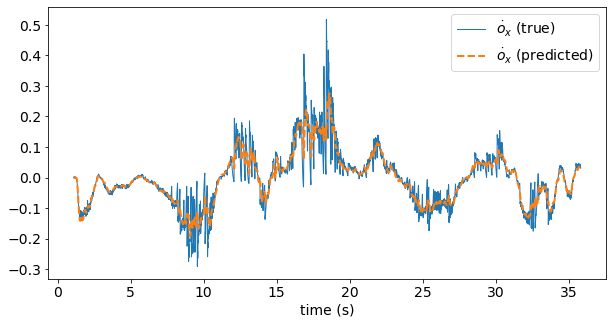

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_x_dot_true, label='$\dot{o}_x$ (true)', linewidth=1)
plt.plot(t, o_x_dot_predicted, '--', label='$\dot{o}_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_x$.

In [47]:
o_x_dot_err = o_x_dot_predicted[:-1] - o_x_dot_true

Plot a histogram of the error, showing mean and standard deviation.

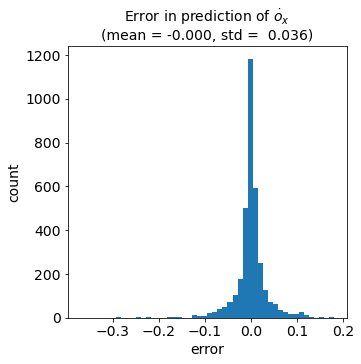

In [48]:
plt.figure(figsize=(5, 5))
plt.hist(o_x_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{o}_x$\n' +
    f'(mean = {np.mean(o_x_dot_err):6.3f}, std = {np.std(o_x_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.2 Error in linear model of $\dot{o}_y$

Approximate $\dot{o}_y$ by finite difference and call this "ground truth."

In [49]:
o_y_dot_true = (o_y[1:] - o_y[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_y_dot_true` is one less than the length of `o_y` (and of `t`):

In [50]:
print(f'len(o_y_dot_true) = {len(o_y_dot_true)}')
print(f'         len(o_y) = {len(o_y)}')
print(f'           len(t) = {len(t)}')

len(o_y_dot_true) = 3475
         len(o_y) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [51]:
o_y_dot_predicted = v_y

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

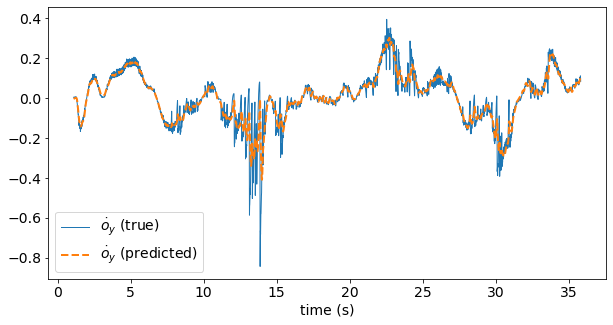

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_y_dot_true, label='$\dot{o}_y$ (true)', linewidth=1)
plt.plot(t, o_y_dot_predicted, '--', label='$\dot{o}_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [53]:
o_y_dot_err = o_y_dot_predicted[:-1] - o_y_dot_true

Plot a histogram of the error, showing mean and standard deviation.

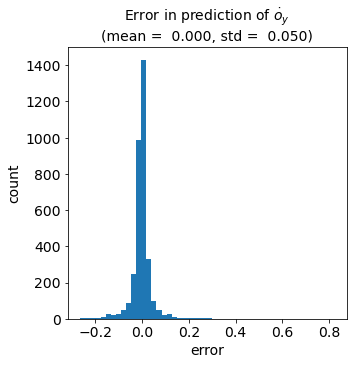

In [54]:
plt.figure(figsize=(5, 5))
plt.hist(o_y_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{o}_y$\n' +
    f'(mean = {np.mean(o_y_dot_err):6.3f}, std = {np.std(o_y_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.3 Error in linear model of $\dot{o}_z$

Approximate $\dot{o}_z$ by finite difference and call this "ground truth."

In [55]:
o_z_dot_true = (o_z[1:] - o_z[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_z_dot_true` is one less than the length of `o_z` (and of `t`):

In [56]:
print(f'len(o_z_dot_true) = {len(o_z_dot_true)}')
print(f'         len(o_z) = {len(o_z)}')
print(f'           len(t) = {len(t)}')

len(o_z_dot_true) = 3475
         len(o_z) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [57]:
o_z_dot_predicted = v_z

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

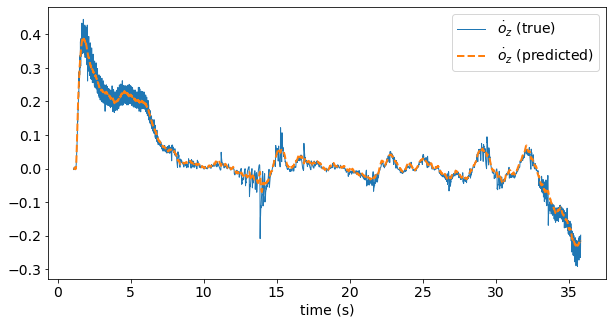

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_z_dot_true, label='$\dot{o}_z$ (true)', linewidth=1)
plt.plot(t, o_z_dot_predicted, '--', label='$\dot{o}_z$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [59]:
o_z_dot_err = o_z_dot_predicted[:-1] - o_z_dot_true

Plot a histogram of the error, showing mean and standard deviation.

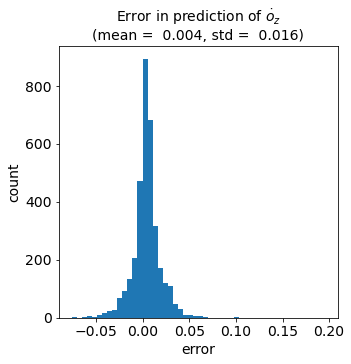

In [60]:
plt.figure(figsize=(5, 5))
plt.hist(o_z_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{o}_z$\n' +
    f'(mean = {np.mean(o_z_dot_err):6.3f}, std = {np.std(o_z_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.4 Error in linear model of $\dot{\psi}$

Approximate $\dot{o}_y$ by finite difference and call this "ground truth."

In [61]:
psi_dot_true = (psi[1:] - psi[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_y_dot_true` is one less than the length of `o_y` (and of `t`):

In [62]:
print(f'len(psi_dot_true) = {len(psi_dot_true)}')
print(f'         len(psi) = {len(psi)}')
print(f'           len(t) = {len(t)}')

len(psi_dot_true) = 3475
         len(psi) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [63]:
psi_dot_predicted = w_z

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

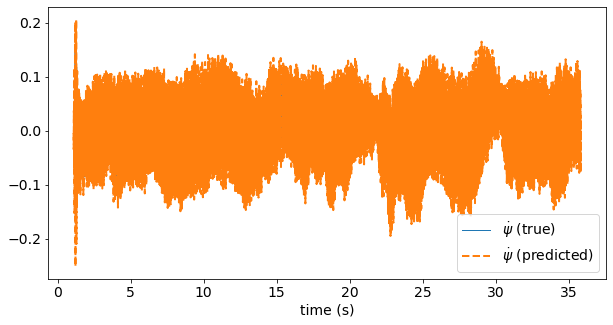

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], psi_dot_true, label='$\dot{\psi}$ (true)', linewidth=1)
plt.plot(t, psi_dot_predicted, '--', label='$\dot{\psi}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [65]:
psi_dot_err = psi_dot_predicted[:-1] - psi_dot_true

Plot a histogram of the error, showing mean and standard deviation.

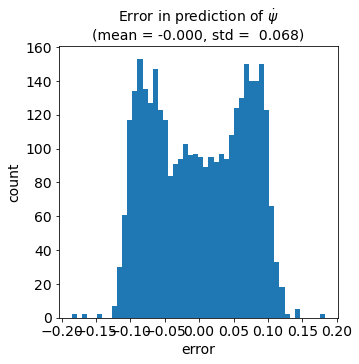

In [66]:
plt.figure(figsize=(5, 5))
plt.hist(psi_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{\psi}$\n' +
    f'(mean = {np.mean(psi_dot_err):6.3f}, std = {np.std(psi_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.5 Error in linear model of $\dot{\theta}$

Approximate $\dot{o}_y$ by finite difference and call this "ground truth."

In [67]:
theta_dot_true = (theta[1:] - theta[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_y_dot_true` is one less than the length of `o_y` (and of `t`):

In [68]:
print(f'len(theta_dot_true) = {len(theta_dot_true)}')
print(f'         len(theta) = {len(theta)}')
print(f'           len(t) = {len(t)}')

len(theta_dot_true) = 3475
         len(theta) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [69]:
theta_dot_predicted = w_y

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

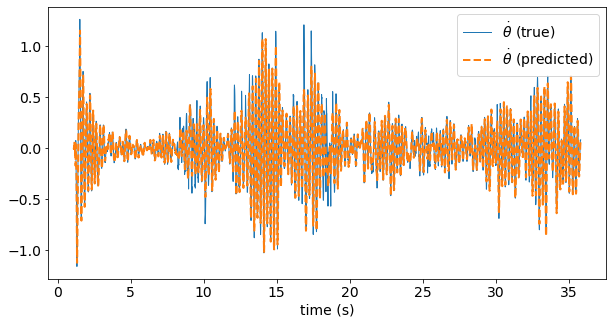

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], theta_dot_true, label=r"$\dot{\theta}$ (true)", linewidth=1)
plt.plot(t, theta_dot_predicted, '--', label=r"$\dot{\theta}$ (predicted)", linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [71]:
theta_dot_err = theta_dot_predicted[:-1] - theta_dot_true

Plot a histogram of the error, showing mean and standard deviation.

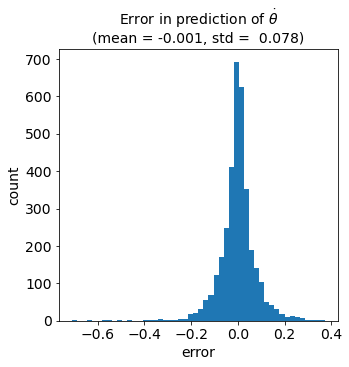

In [72]:
plt.figure(figsize=(5, 5))
plt.hist(theta_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    r"Error in prediction of $\dot{\theta}$" + '\n' + 
    f'(mean = {np.mean(theta_dot_err):6.3f}, std = {np.std(theta_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.6 Error in linear model of $\dot{\phi}$

Approximate $\dot{o}_y$ by finite difference and call this "ground truth."

In [73]:
phi_dot_true = (phi[1:] - phi[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_y_dot_true` is one less than the length of `o_y` (and of `t`):

In [74]:
print(f'len(phi_dot_true) = {len(phi_dot_true)}')
print(f'         len(phi) = {len(phi)}')
print(f'           len(t) = {len(t)}')

len(phi_dot_true) = 3475
         len(phi) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [75]:
phi_dot_predicted = w_x

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

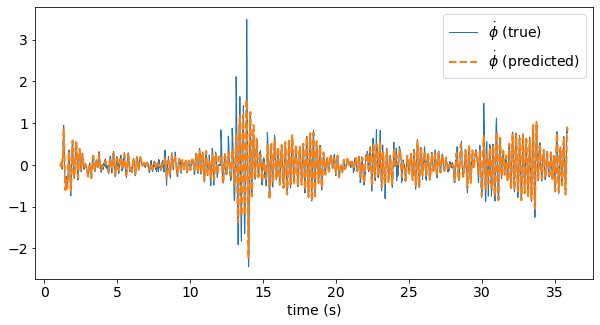

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], phi_dot_true, label=r"$\dot{\phi}$ (true)", linewidth=1)
plt.plot(t, phi_dot_predicted, '--', label=r"$\dot{\phi}$ (predicted)", linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [77]:
phi_dot_err = phi_dot_predicted[:-1] - phi_dot_true

Plot a histogram of the error, showing mean and standard deviation.

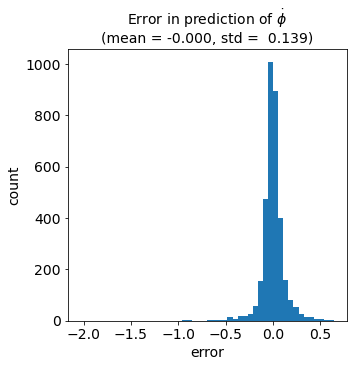

In [78]:
plt.figure(figsize=(5, 5))
plt.hist(phi_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    r"Error in prediction of $\dot{\phi}$" + '\n' + 
    f'(mean = {np.mean(phi_dot_err):6.3f}, std = {np.std(phi_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.7 Error in linear model of $\dot{v}_x$

Approximate $\dot{o}_z$ by finite difference and call this "ground truth."

In [79]:
v_x_dot_true = (v_x[1:] - v_x[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_z_dot_true` is one less than the length of `o_z` (and of `t`):

In [80]:
print(f'len(v_x_dot_true) = {len(v_x_dot_true)}')
print(f'         len(v_x) = {len(v_x)}')
print(f'           len(t) = {len(t)}')

len(v_x_dot_true) = 3475
         len(v_x) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [81]:
v_x_dot_predicted = g * theta

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

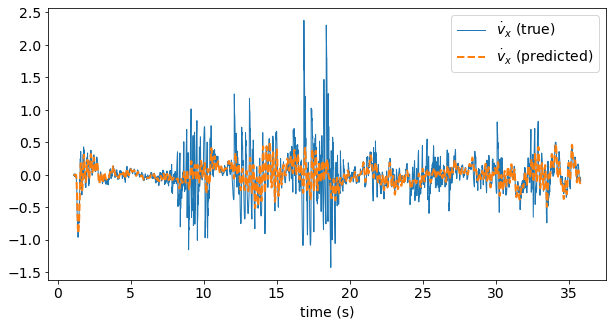

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_x_dot_true, label='$\dot{v}_x$ (true)', linewidth=1)
plt.plot(t, v_x_dot_predicted, '--', label='$\dot{v}_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [83]:
v_x_dot_err = v_x_dot_predicted[:-1] - v_x_dot_true

Plot a histogram of the error, showing mean and standard deviation.

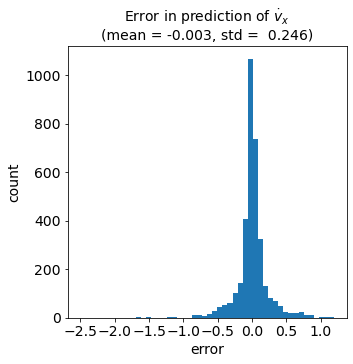

In [84]:
plt.figure(figsize=(5, 5))
plt.hist(v_x_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{v}_x$\n' +
    f'(mean = {np.mean(v_x_dot_err):6.3f}, std = {np.std(v_x_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.8 Error in linear model of $\dot{v}_y$

Approximate $\dot{o}_z$ by finite difference and call this "ground truth."

In [85]:
v_y_dot_true = (v_y[1:] - v_y[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_z_dot_true` is one less than the length of `o_z` (and of `t`):

In [86]:
print(f'len(v_y_dot_true) = {len(v_y_dot_true)}')
print(f'         len(v_y) = {len(v_y)}')
print(f'           len(t) = {len(t)}')

len(v_y_dot_true) = 3475
         len(v_y) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [87]:
v_y_dot_predicted = -g * phi

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

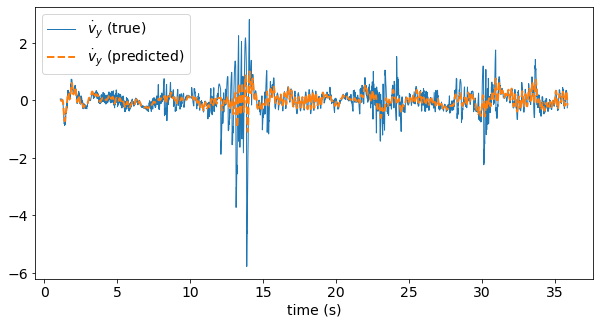

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_y_dot_true, label='$\dot{v}_y$ (true)', linewidth=1)
plt.plot(t, v_y_dot_predicted, '--', label='$\dot{v}_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [89]:
v_y_dot_err = v_y_dot_predicted[:-1] - v_y_dot_true

Plot a histogram of the error, showing mean and standard deviation.

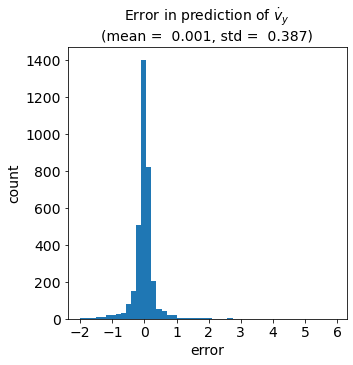

In [90]:
plt.figure(figsize=(5, 5))
plt.hist(v_y_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{v}_y$\n' +
    f'(mean = {np.mean(v_y_dot_err):6.3f}, std = {np.std(v_y_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.9 Error in linear model of $\dot{v}_z$

Approximate $\dot{o}_z$ by finite difference and call this "ground truth."

In [91]:
v_z_dot_true = (v_z[1:] - v_z[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_z_dot_true` is one less than the length of `o_z` (and of `t`):

In [92]:
print(f'len(v_z_dot_true) = {len(v_z_dot_true)}')
print(f'         len(v_z) = {len(v_z)}')
print(f'           len(t) = {len(t)}')

len(v_z_dot_true) = 3475
         len(v_z) = 3476
           len(t) = 3476


Predict $\dot{o}_y$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_y$, and that the first element of $Ax+Bu$ is $v_y$. So, our state-space model tells us that $\dot{o}_y \approx v_y$.

In [93]:
v_z_dot_predicted = a_z - g

Compare the true value and the predicted values of $\dot{o}_y$ in a plot.

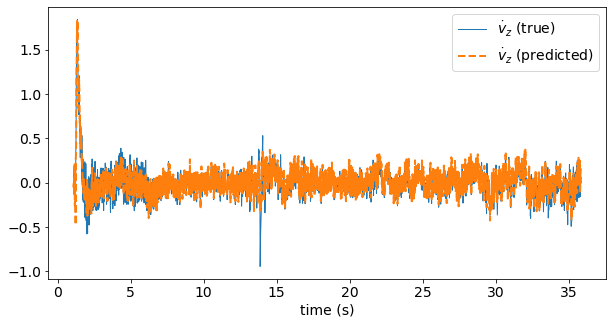

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_z_dot_true, label='$\dot{v}_z$ (true)', linewidth=1)
plt.plot(t, v_z_dot_predicted, '--', label='$\dot{v}_z$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_y$.

In [95]:
v_z_dot_err = v_z_dot_predicted[:-1] - v_z_dot_true

Plot a histogram of the error, showing mean and standard deviation.

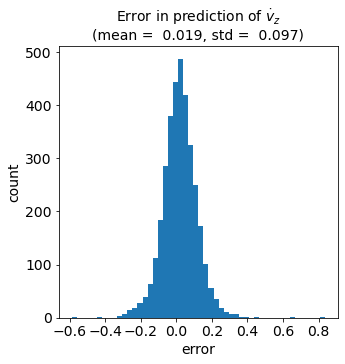

In [96]:
plt.figure(figsize=(5, 5))
plt.hist(v_z_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $\dot{v}_z$\n' +
    f'(mean = {np.mean(v_z_dot_err):6.3f}, std = {np.std(v_z_dot_err):6.3f})',
    fontsize=14,
)
plt.show()

## 4.3 Error in linearized measurement equations

### 4.3.1 Error in linear model of $x_{meas}$

Predict $x_{meas}$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $x_{meas}$, and that the first element of $Cx+Du$ is

$$o_x,$$

so our linear model tells us that

$$x_{meas} \approx o_x.$$

In [97]:
x_meas_predicted = o_x

Compare the true value and the predicted values of $n_x$ in a plot.

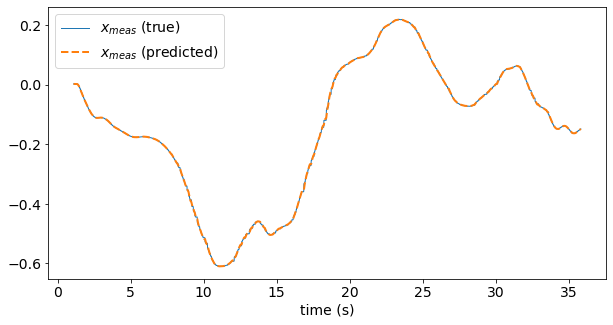

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(t, x_meas, label='$x_{meas}$ (true)', linewidth=1)
plt.plot(t, x_meas_predicted, '--', label='$x_{meas}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [99]:
x_meas_err = x_meas_predicted - x_meas

Plot a histogram of the error, showing mean and standard deviation.

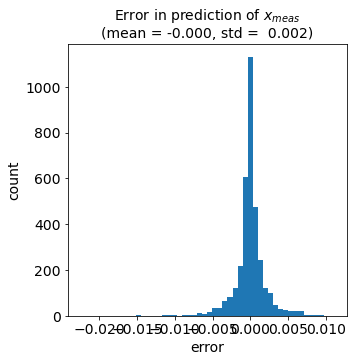

In [100]:
plt.figure(figsize=(5, 5))
plt.hist(x_meas_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $x_{meas}$\n' +
    f'(mean = {np.mean(x_meas_err):6.3f}, std = {np.std(x_meas_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.2 Error in linear model of $y_{meas}$

Predict $y_{meas}$ with the linearized measurement equations.

In particular, note that the second element of $y$ is $y_{meas}$, and that the second element of $Cx+Du$ is

$$o_y,$$

so our linear model tells us that

$$y_{meas} \approx o_y.$$

In [101]:
y_meas_predicted = o_y

Compare the true value and the predicted values of $n_x$ in a plot.

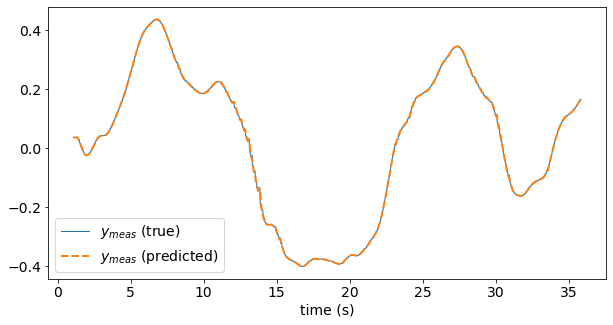

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(t, y_meas, label='$y_{meas}$ (true)', linewidth=1)
plt.plot(t, y_meas_predicted, '--', label='$y_{meas}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [103]:
y_meas_err = y_meas_predicted - y_meas

Plot a histogram of the error, showing mean and standard deviation.

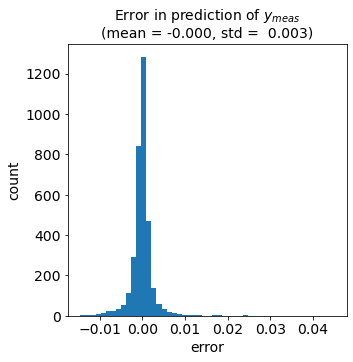

In [104]:
plt.figure(figsize=(5, 5))
plt.hist(y_meas_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $y_{meas}$\n' +
    f'(mean = {np.mean(y_meas_err):6.3f}, std = {np.std(y_meas_err):6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.3 Error in linear model of $z_{meas}$

Predict $z_{meas}$ with the linearized measurement equations.

In particular, note that the second element of $y$ is $z_{meas}$, and that the second element of $Cx+Du$ is

$$o_z,$$

so our linear model tells us that

$$z_{meas} \approx o_z.$$

In [105]:
z_meas_predicted = o_z

Compare the true value and the predicted values of $z_{meas}$ in a plot.

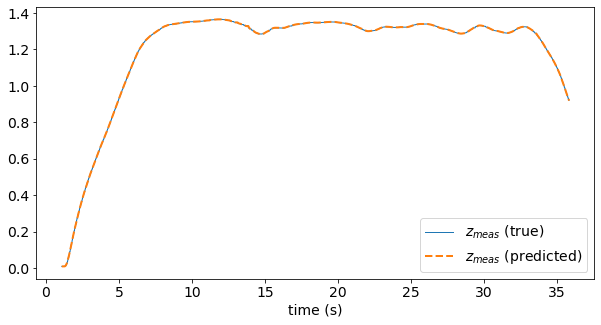

In [106]:
plt.figure(figsize=(10, 5))
plt.plot(t, z_meas, label='$z_{meas}$ (true)', linewidth=1)
plt.plot(t, z_meas_predicted, '--', label='$z_{meas}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $z_{meas}$.

In [107]:
z_meas_err = z_meas_predicted - z_meas

Plot a histogram of the error, showing mean and standard deviation.

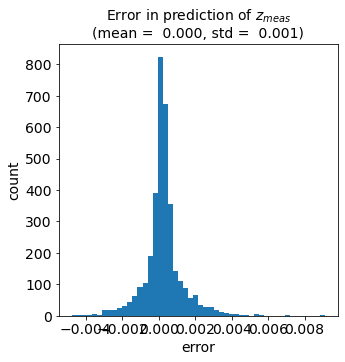

In [108]:
plt.figure(figsize=(5, 5))
plt.hist(z_meas_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Error in prediction of $z_{meas}$\n' +
    f'(mean = {np.mean(z_meas_err):6.3f}, std = {np.std(z_meas_err):6.3f})',
    fontsize=14,
)
plt.show()

## 4.4 Summary

The following table reports the mean and standard deviation of error in the linearized equations of motion:

|  | $\dot{o}_x$ | $\dot{o}_y$ | $\dot{o}_z$ | $\dot{\psi}$ | $\dot{\theta}$ | $\dot{\phi}$ | $\dot{v}_x$ | $\dot{v}_y$ | $\dot{v}_z$ |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| mean | 0.001 | 0.000 | 0.009 | -0.001 | 0.000 | 0.000 | -0.004 | -0.002 | 0.000 |
| std | 0.070 | 0.064 | 0.027 | 0.063 | 0.056 | 0.084 | 0.298 | 0.265 | 0.000 |

The following table reports the mean and standard deviation of error in the linearized measurement equations:

|  | $x_{meas}$ | $y_{meas}$ | $z_{meas}$ |
| :--: | :--: | :--: | :--: |
| mean | -0.096 | -0.185 | -0.025 |
| std | 0.071 | 0.060 | 0.090 |

**Modify the text in this cell** to answer the following questions:

* Which equations of motion do you trust most (or least) and why?
* Which measurement equations do you trust most (or least) and why?

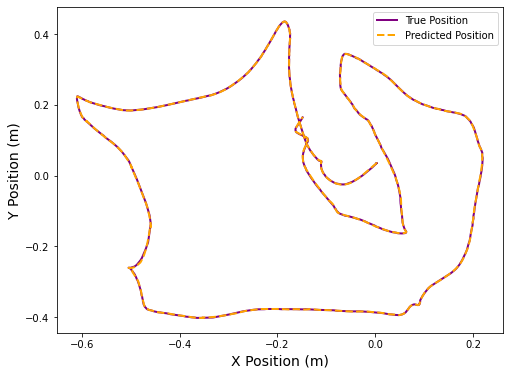

In [132]:
fig = plt.figure(figsize=(8, 6))
plt.plot(x_meas, y_meas, label='True Position', linewidth=2, color='purple')

plt.plot(x_meas_predicted, y_meas_predicted, '--', label='Predicted Position', linewidth=2, color='orange')
plt.ylabel('Y Position (m)', size=14)
plt.xlabel('X Position (m)', size=14)
plt.legend()
plt.show()


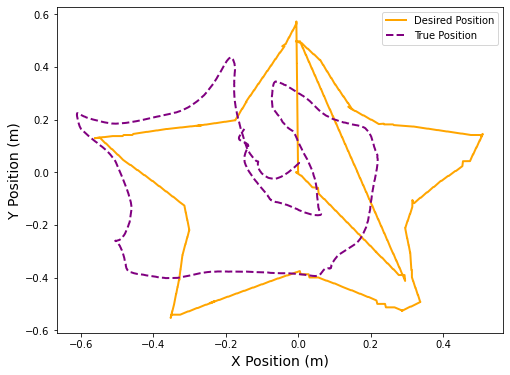

In [133]:
fig = plt.figure(figsize=(8, 6))
plt.plot(x_des, y_des, label='Desired Position', linewidth=2, color='orange')

plt.plot(x_meas, y_meas, '--', label='True Position', linewidth=2, color='purple')
plt.legend()
plt.ylabel('Y Position (m)', size=14)
plt.xlabel('X Position (m)', size=14)
plt.show()
